<center>

---
---

# SPT-3G JAX Likelihood
# Automatic Differentiation Demo

</center>

---
---

This notebook demonstrates the basic usage of the SPT-3G JAX likelihood with a focus on automatic differentiation.
It also shows how to use some of the auxiliary tools. Below, we will:

- Initialise a likelihood
- Generate mock data
- Find the best-fit model using a gradient-based algorithm
- Visualise the Fisher matrix and the path of a minimisation algorithm
- Print the expected parameter errors and compare to other CMB experiments
- Plot the foreground contributions to the best-fit spectrum


In [1]:
# Necessary imports and setup
%matplotlib widget

import jax
import jax.numpy as jnp
import numpy as np

import sys

# Change to the path to your likelihood installation here!
#sys.path.append('/Users/lennart/Research/SPT3G_JAX_Likelihood')

import candl
import candl.interface
import candl.tools
import candl.plots

import matplotlib.pyplot as plt

from copy import deepcopy

import sigfig


In [2]:
# Set the plot style (font siezes, tick widths, ...)
candl.plots.set_plot_style()


# Initialise the Likelihood

In [3]:
# Here we initialise the likelihood by pointing it to the data set .yaml file
# This file in turn contains all the necessary info, e.g. the spectra we are 
# fitting, the band power file, the covariance file, information on the priors, etc.
dataset_file = "../real_data/ACT_DR4_CMB_only/ACT_DR4_CMB_only.yaml"
spt3g_2018_ttteee = candl.Like(dataset_file)


Successfully initialised candl likelihood 'ACT DR4 TT/TE/EE (Choi et al. 2020, Aiola et al. 2020)' (type: <class 'candl.likelihood.Like'>).
Data loaded from '../real_data/ACT_DR4_CMB_only/'.
Functional likelihood form: gaussian
--------------------------------------------------------------------------------
It will analyse the following spectra:

TT dxd       (40 bins, bin centres spanning ell = 600.3 - 4123.0)
TE dxd       (45 bins, bin centres spanning ell = 350.5 - 4123.0)
EE dxd       (45 bins, bin centres spanning ell = 350.3 - 4122.9)
TT wxw       (40 bins, bin centres spanning ell = 600.4 - 4122.3)
TE wxw       (45 bins, bin centres spanning ell = 350.5 - 4122.4)
EE wxw       (45 bins, bin centres spanning ell = 350.4 - 4122.4)
--------------------------------------------------------------------------------
A data model consisting of 1 transformations has been initialised.
The following transformations will be applied to the theory spectra in this order:

(1) Name: Calibration
 

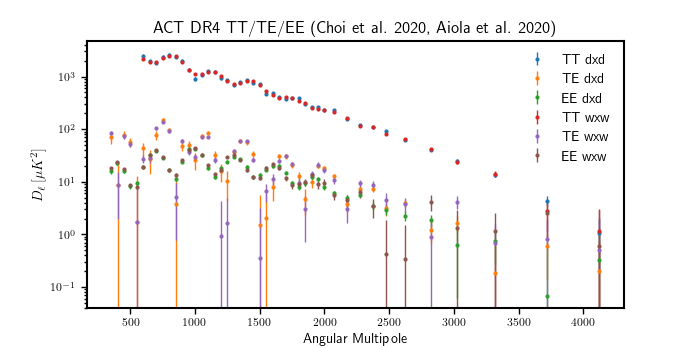

No such comm: cb0778f21ae6489797212cb121143889


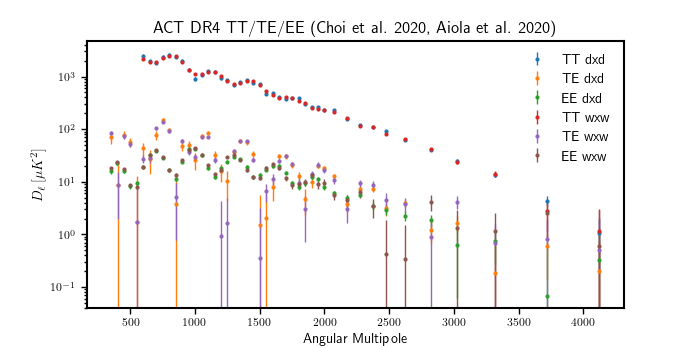

No such comm: 39a6c706f00b4b6d90a8b4062aa5bb95


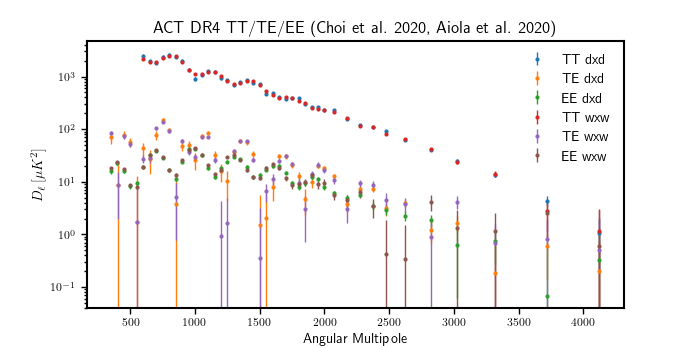

No such comm: 2e46d22d50fc47b2acc0b5a15092cf91


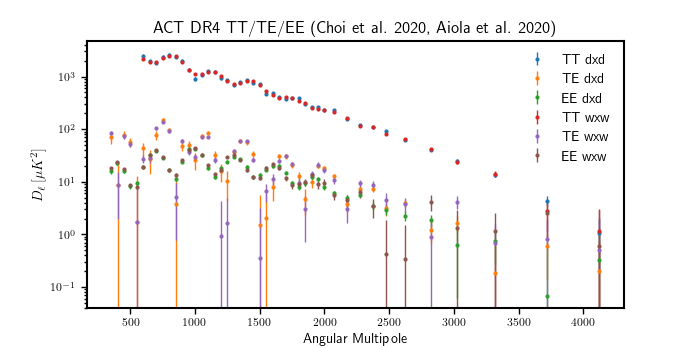

No such comm: 1362446ac135440ab49c9717c7243471


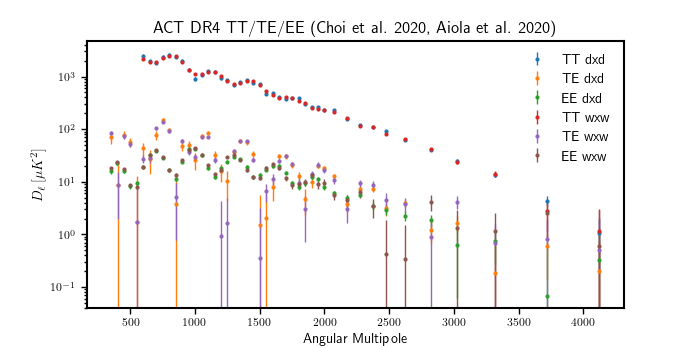

No such comm: ec83ba49e7f84be189869b1de923b5ce


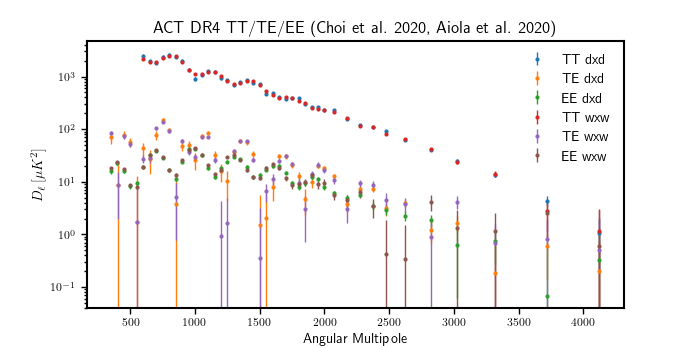

In [4]:
plt.close()

candl.plots.plot_band_powers(spt3g_2018_ttteee)

plt.show()

# Generate Mock Data

In [5]:
# Grab a theory calculator and initialise it
# Here, we use our differentiable, high-precision CosmoPower models
# These take care of the step of moving from cosmological parameters to theory Cls
cp_emulator_filenames = {"TT": "cmb_spt_TT_NN",
                         "TE": "cmb_spt_TE_PCAplusNN",
                         "EE": "cmb_spt_EE_NN"}
theory_calc = candl.interface.CobayaTheoryCosmoPowerJAX(cp_emulator_filenames)
pars_to_theory_specs = candl.interface.get_cobaya_pars_to_theory_specs_func(theory_calc)

# Define fiducial parameters - cosmological ones by hand
fid_pars = {'H0': 67.37,
            'ombh2': 0.02233,
            'omch2': 0.1198,
            'logA': 3.043,
            'ns': 0.9652,
            'tau': 0.054}
fid_pars["yp"] = 1.0

# Nuisance parameters are set to the central values of their priors
for par_name in spt3g_2018_ttteee.required_nuisance_parameters:
    for prior in spt3g_2018_ttteee.priors:
        if par_name in prior.par_names:
            fid_pars[par_name] = prior.central_value[prior.par_names.index(par_name)]



# Minimiser

In [6]:
# Here, we grab a function that moves from parameters to logl all in one step.
# This is a light wrapper that combines our theory calculator (CosmoPower) and our likelihood.
# There's a bit of glue in-between, which crops the spectra to the right ell range.
# We also grab the derivative and the Hessian
like = jax.jit(candl.tools.get_params_to_logl_func(spt3g_2018_ttteee, pars_to_theory_specs))
like_deriv = jax.jit(jax.jacfwd(like))
like_hessian = jax.jit(jax.hessian(like))


In [7]:
# Run the minimisers!
# We run a simple Newton-Raphson minimiser 3 times with different starting points.
# Notice how the first one or two evaluations of the hessian and the derivative functions are quite slow.
# This is due to our use of jit() above.
# However, subsequent iterations are much faster, meaning as a whole this saves time.

# We want to minimise all parameters - cosmological ones and nuisance parameters
pars_for_min = ["H0", "ombh2", "omch2", "ns", "logA", "tau"] + spt3g_2018_ttteee.required_nuisance_parameters

# Details of the minimiser algorithm - more small steps lead to better stability
step_size = 0.15
N_newton = 20
N_min = 3

# Set the fiducial starting point
starting_pars = deepcopy(fid_pars)
start_scatter = {"H0": 0.5, "ombh2": 0.00005, "omch2": 0.001, "ns": 0.005}
for p in list(starting_pars.keys()):
    starting_pars[p] = jnp.float64(starting_pars[p]) # Make sure its all floats

# Start multiple minimisers
all_eval_points = []
all_eval_par_covs = []
for i_min in range(N_min):
    
    # Add scatter to starting point
    this_starting_pars = deepcopy(starting_pars)
    this_starting_pars, start_box = candl.tools.add_uniform_scatter(start_params = this_starting_pars,# fiducial starting point
                                                                    box_width = 5,# inflates the passed parameter errors
                                                                    par_errs = start_scatter,# scale of the scatter
                                                                    seed = i_min)# RNG seed for scatter
        
    # Step through minimiser
    eval_points, eval_par_cov = candl.tools.newton_raphson_minimiser(like_deriv = like_deriv,# Derivative function
                                                                     like_hess = like_hessian,# Hessian function
                                                                     starting_pars = this_starting_pars,# Start point
                                                                     pars_for_min = pars_for_min,# Which parameters to minimise
                                                                     N_newton = N_newton,# How many steps to take
                                                                     step_size = step_size,# Scaling of the step size
                                                                     show_progress = True)# Show loading bars
    
    # Increment
    all_eval_points.append(eval_points)
        
    all_eval_par_covs.append(eval_par_cov)
    print(f"Finished minimiser: {i_min}")


  0%|          | 0/20 [00:00<?, ?it/s]

Finished minimiser: 0


  0%|          | 0/20 [00:00<?, ?it/s]

Finished minimiser: 1


  0%|          | 0/20 [00:00<?, ?it/s]

Finished minimiser: 2


In [8]:
# Analyse the minimisers and check convergence
# This is actually the first time we evaluate the log likelihood itself
# (we only accessed its derivate and Hessian before), so we have a little jit delay here too

min_logl = np.array([like(all_eval_points[i_min][-1]) for i_min in range(N_min)])
min_spread = np.amax(min_logl)-np.amin(min_logl)
min_ix = np.argmax(min_logl)

print(f"{N_min} minimisers agree to within {min_spread}")
print(f"Best minimiser index: {min_ix}")


3 minimisers agree to within 0.010716125235603613
Best minimiser index: 1


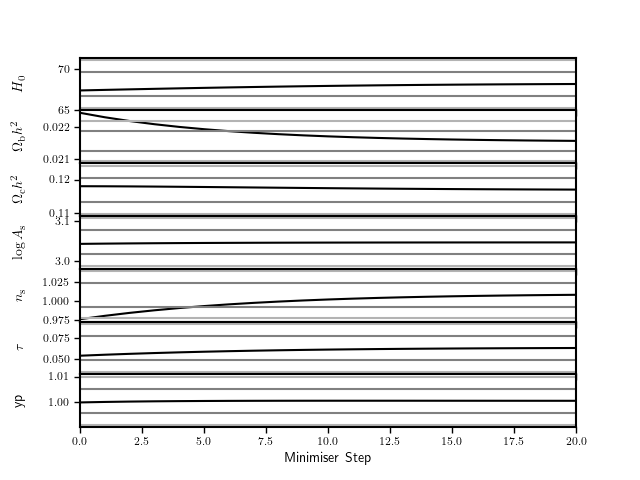

In [9]:
plt.close()

candl.plots.plot_minimiser_convergence(all_eval_points[min_ix], par_cov=all_eval_par_covs[min_ix][-1], par_cov_order=pars_for_min, relative=False)

plt.show()


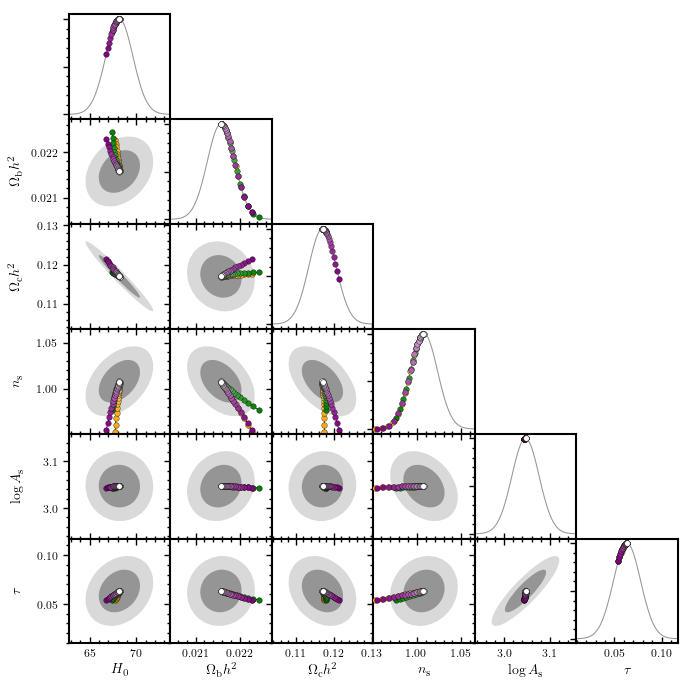

In [19]:
# Make a triangle plot and trace the journey of the minimiser!
# Here we plot the trajectories the three minimisers take.
# We also show expected parameter errors based on the Hessian, which gives the problem some scale.
# Since the Hessian is already computed for the minimiser, we can re-use it.
# Note though, that we are assuming here that parameter posteriors are Gaussian, i.e. the Fisher matrix
# captures everything. That's not always the case (and the reason we run chains), but for LCDM, this
# is close enough!

# Only plot cosmological parameters
pars_to_plot = ["H0", "ombh2", "omch2", "ns", "logA", "tau"]

plt.close()

# Plot parameters
sigma_plot_range = 3
sigma_levels = 2

ax = candl.plots.triangle_plot_from_cov(pars_to_plot = pars_to_plot,# which parameters to plot
                                        bf_point = all_eval_points[min_ix][-1],# the best-fit point
                                        par_cov = all_eval_par_covs[min_ix][-1],# the parameter covariance matrix
                                        pars_in_cov = pars_for_min,# the order of parameters in the covariance
                                        sigma_plot_range = sigma_plot_range,# sets the axes limits
                                        sigma_levels = sigma_levels)# how many sigma levels to plot

# Loop over the three minimisers and show their paths with different colours.
# The trajectories start out in full colour, but get progressively lighter.
# Final points of the minimisers are shown in white.
for i_min, colour in zip(range(N_min),
                         ["orange", "green", "purple"]):
    
    candl.plots.add_min_trajectory(ax = ax,# axis instance
                                   pars_to_plot = pars_to_plot,# which parameters to plot
                                   eval_points = all_eval_points[i_min],# a list of all the points in the minimiser trajectory
                                   par_cov = all_eval_par_covs[min_ix][-1],# covariance of the best run - this is used to set the correct height in the 1d panels
                                   pars_in_cov = pars_for_min,# the order of parameters in the covariance
                                   bf_point = all_eval_points[min_ix][-1],# the best-fit point - again used in the 1d panels
                                   base_colour = colour)# the base colour used to show the trajectory path

plt.tight_layout()

plt.show()


# Forecasting Table

In [20]:
# SPT-3G 2018 TT/TE/EE
TTTEEE_2018_err = {'H0': 1.5160214203356237,
                   'ombh2': 0.000322216024773666,
                   'omch2': 0.0037534404453850277,
                   'logA': 0.020669424949084223,
                   'ns': 0.016349705976406177,
                   'tau': 0.007431270176549568}

# Planck 2018 TT/TE/EE (no lensing)
Planck_err = {'H0': 0.6040822485825148,
              'ombh2': 0.00014879589662060205,
              'omch2': 0.0013661348428128588,
              'logA': 0.015912757804328707,
              'ns': 0.004368113694735629,
              'tau': 0.007874859680296484}

# ACT DR4 TT/TE/EE - rerun with Planck tau prior
ACT_DR4_err = {'H0': 1.5008356990398566,
               'ombh2': 0.00030924869865155537,
               'omch2': 0.003819334804221818,
               'logA': 0.019731015218254284,
               'ns': 0.015469851489957111,
               'tau': 0.007156109540164022}


In [21]:
# Let's compare constrainting power across experiments and print a simple forecasting table
# Again, note that we are assuming here that parameter posteriors are Gaussian, i.e. the Fisher matrix
# captures everything. That's not always the case (and the reason we run chains), but for LCDM, this
# is close enough!

# Use the latest Hessian evaluation of the minimiser as the parameter covariance matrix
par_cov = deepcopy(all_eval_par_covs[min_ix][-1])

# Juggle into a dictionary
par_errs_dict = {}
for i,p in enumerate(pars_for_min):
    par_errs_dict[p] = jnp.sqrt(par_cov[i,i])

exp_to_compare = {"SPT-3G 2018": TTTEEE_2018_err,
                  "ACT DR4": ACT_DR4_err,
                  "SPT-3G Winter 19/20": par_errs_dict,
                  "Planck 2018": Planck_err,}

# Set a reference experiment
ref_exp = "SPT-3G 2018"

# Print Header
cos_pars = ["H0", "ombh2", "omch2", "ns", "logA"]#
header_str = ""
header_str += "{:<20} | ".format("Experiment")
for par in cos_pars:
    header_str += "{:<13} | ".format(par)
print(header_str)
print(len(header_str[:-1])*"-")

# Loop over experiments
for exp in list(exp_to_compare.keys()):
    print("{:<20} | ".format(exp), end="")
    
    # Print constraints
    for par in cos_pars:
        ratio = exp_to_compare[exp][par]/exp_to_compare[ref_exp][par]
        
        # Either print with the ratio to the reference experiment or not
        if exp == ref_exp:
            print("{:<13} | ".format(sigfig.round(float(exp_to_compare[exp][par]), sigfigs=2)), end="")
        else:
            print("{:<7} ({:<4})| ".format(sigfig.round(float(exp_to_compare[exp][par]), sigfigs=2),
                                           sigfig.round(float(ratio), decimals=2)), end="")
    
    print("")
print(len(header_str[:-1])*"-")


Experiment           | H0            | ombh2         | omch2         | ns            | logA          | 
------------------------------------------------------------------------------------------------------
SPT-3G 2018          | 1.5           | 0.00032       | 0.0038        | 0.016         | 0.021         | 
ACT DR4              | 1.5     (0.99)| 0.00031 (0.96)| 0.0038  (1.02)| 0.015   (0.95)| 0.02    (0.95)| 
SPT-3G Winter 19/20  | 1.5     (0.97)| 0.00031 (0.96)| 0.0036  (0.96)| 0.015   (0.93)| 0.03    (1.46)| 
Planck 2018          | 0.6     (0.4 )| 0.00015 (0.46)| 0.0014  (0.36)| 0.0044  (0.27)| 0.016   (0.77)| 
------------------------------------------------------------------------------------------------------


# Foreground Contributions

In [22]:
# Lastly, we show the foreground contributions for the best-fit model.

plt.close()

# Grab a dictionary of foreground contributions for each spectrum from the likelihood
fg_dict = spt3g_like.get_foreground_contributions(all_eval_points[min_ix][-1],# Best-fit point
                                                  return_type="dict by spec")# Specific return type

# Pass to plotting function
fig, ax = spt3g_plots.plot_foreground_components(spt3g_like,# Likelihood
                                                 fg_dict)# Dictionary of foreground contributions

plt.show()


NameError: name 'spt3g_like' is not defined